In [11]:
import numpy as np
import pandas as pd
import datetime
import pickle
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [12]:
## ADDITIONAL FUNCTIONS
if not os.path.exists('models'):
    os.makedirs('models')

pStopWordsList = stopwords.words('english') + stopwords.words('russian')
    
def process_text_layer(TextLayer, pStopWordsList = []):
    txt =  " ".join([w for w in TextLayer.lower().split() \
                     if (not w in pStopWordsList)])

    txt = txt. \
        replace('«', ''). \
        replace('»', ''). \
        replace('(', ''). \
        replace(')', ''). \
        replace('\[)', ''). \
        replace('\]', ''). \
        replace('^', ''). \
        replace('\\', '')

    return txt

def learnBinaryClassifier(ds):
    '''Kлассификатор. 
   Input: ds (dataframe): x - текстовый слой; target - результат
   Output: CountVectorizer, RandomForestClassifier
   '''
    ngram_range = (1, 3)
    max_features = 50000
    n_estimators=100

    print("Create vectorizer")
    vectorizer = CountVectorizer(analyzer = "word",
                                tokenizer = None,
                                preprocessor = None,
                                stop_words = None, 
                                ngram_range = ngram_range,
                                max_features = max_features
                                )

    print("Fit and Transform vectorizer")

    X_train = ds['x']
    Y_train = ds['target']

    X_train = vectorizer.fit_transform(X_train)
    X_train = X_train.toarray()

    model = RandomForestClassifier(n_estimators=n_estimators)

    print("Fit Model")
    model = model.fit(X_train, Y_train)

    return vectorizer, model

In [13]:
def learnBinaryClassifier_CountVectorizer(ds):
    '''Kлассификатор. 
   Input: ds (dataframe): x - текстовый слой; target - результат
   Output: CountVectorizer, RandomForestClassifier
   '''
    ngram_range = (1, 3)
    max_features = 50000
    n_estimators=100

    print("Create vectorizer")
    vectorizer = CountVectorizer(analyzer = "word",
                                tokenizer = None,
                                preprocessor = None,
                                stop_words = None, 
                                ngram_range = ngram_range,
                                max_features = max_features
                                )

    print("Fit and Transform vectorizer")

    X_train = ds['x']
    Y_train = ds['target']

    X_train = vectorizer.fit_transform(X_train)
    X_train = X_train.toarray()

    model = RandomForestClassifier(n_estimators=n_estimators)

    print("Fit Model")
    model = model.fit(X_train, Y_train)

    return vectorizer, model
def learnBinaryClassifier_TF_IDF(ds):
    '''Kлассификатор. 
   Input: ds (dataframe): x - текстовый слой; target - результат
   Output: CountVectorizer, RandomForestClassifier
   '''
    ngram_range = (1, 3)
    max_features = 50000
    n_estimators=100

    print("Create vectorizer")
    vectorizer = TfidfVectorizer(analyzer = "word",
                                tokenizer = None,
                                preprocessor = None,
                                stop_words = None, 
                                ngram_range = ngram_range,
                                max_features = max_features
                                )

    print("Fit and Transform vectorizer")

    X_train = ds['x']
    Y_train = ds['target']

    X_train = vectorizer.fit_transform(X_train)
    X_train = X_train.toarray()

    model = RandomForestClassifier(n_estimators=n_estimators)

    print("Fit Model")
    model = model.fit(X_train, Y_train)

    return vectorizer, model


In [14]:
text_data = pd.read_csv('CLASS PROSPECTUS.csv')
text_data['string_value'] = text_data['string_value'].astype(str)
class_data = pd.read_excel('CLASS PROSPECTUS.xlsx', sheet_name = 'DATA')

models_rename = {
    "Ограничение по предоставлению залога":"Restriction_on_the_provision_of_collateral",
    "Изменение контроля":"Change_of_control",
    "Случаи дефолта":"Cases_of_default",
    "Кросс-дефолт":"Cross-default",
    "Оговорки о коллективных действиях":"Collective_action_clauses",
    "Ограничение задолженности":"Limitation_on_indebtedness",
    "Ограничение задолженности дочерних компаний":"Limitation_of_debt_of_subsidiaries",
    "Ограничение по платежам":"Limitation_on_payments",
    "Ограничение по инвестициям":"Investment_restriction",
    "Ограничение по платежам в отношении дочерних компаний":"Limitation_on_payments_to_subsidiaries",
    "Ограничение по транзакциям с аффилированными лицами":"Restriction_on_transactions_with_affiliates",
    "Ограничение деятельности":"Restriction_of_activity",
    "Ограничение по продаже активов":"Restriction_on_asset_sales",
    "Ограничение по продаже активов с обратной арендой":"Restriction_on_the_sale_of_assets_with_leaseback",
    "Ограничение по слиянию":"Limitation_on_merger",
    "Триггер рейтингов":"Ratings_trigger",
    "Обозначение прав дочерних компаний (restricted / unrestricted)":"Designation_of_the_rights_of_subsidiaries",
    "Ограничение по наслоению долговых обязательств по рангам":"Restriction_on_the_layering_of_debt_obligations_by_rank",
    "Условие приостановки действия ковенантов":"A_condition_of_suspension_of_the_covenants",
    "Финансовые ковенанты":"Financial_covenants"}
class_data = class_data.rename(columns=models_rename)

In [15]:
# Уменьшаем размерность задачи, так как слишком много нулевых данных
tags = list(class_data['tag'])
new_tags = list(text_data[~text_data['tag'].isin(tags)].sample(3000)['tag'])
new_tags = new_tags + tags
text_data = text_data[text_data['tag'].isin(new_tags)]

In [16]:
data = text_data.merge(class_data, on='tag', how='left').copy()
data['string_value'] = data.apply(lambda r: process_text_layer(r['string_value'], pStopWordsList), axis = 1)
models = list(data.columns)[2:]

In [17]:
# По ковенанте ratings_trigger и Обозначение прав нет ни одного документа, её содержащего, так что вырежем её из списка моделей
if "Ratings_trigger" in models:
    models.remove("Ratings_trigger")
if "Обозначение прав дочерних компаний (restricted unrestricted)" in models:
    models.remove("Обозначение прав дочерних компаний (restricted unrestricted)")


In [18]:
datasets = {}
#models = ['Change_of_control']
for model_name in models:
    ds = data[['tag','string_value', model_name]].rename(columns={'string_value': 'x', model_name: 'target'})
    ds = ds.fillna(0)
    ds = ds[ds['target']!=''].drop_duplicates()
    datasets[model_name] = ds.copy()

In [19]:
validation_set_part = 0.2
for model_name in models:
    df = datasets[model_name]
    df_validation = df.sample(frac = validation_set_part) 
    df_training = df.drop(df_validation.index) 
    item = {
        'df_validation': df_validation.copy(),
        'df_training': df_training.copy()
    }
    datasets[model_name] = item

In [26]:
for model_name in models:
    vector, model = learnBinaryClassifier_CountVectorizer(datasets[model_name]['df_training'])
    with open(('models/CLASS_PROSPECTUS_{}_CountVectorizer.rft'.format(model_name)), 'wb') as f:
        pickle.dump(model, f)
    with open(('models/VECTOR_PROSPECTUS_{}_CountVectorizer.txt'.format(model_name)), 'wb') as f:
        pickle.dump(vector, f)
    vector, model = learnBinaryClassifier_TF_IDF(datasets[model_name]['df_training'])
    with open(('models/CLASS_PROSPECTUS_{}_TF-IDF.rft'.format(model_name)), 'wb') as f:
        pickle.dump(model, f)
    with open(('models/VECTOR_PROSPECTUS_{}_TF-IDF.txt'.format(model_name)), 'wb') as f:
        pickle.dump(vector, f)

Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Transform vectorizer
Fit Model
Create vectorizer
Fit and Trans

In [45]:
for model_name in models:
    with open(('./models\\CLASS_PROSPECTUS_%s.rft' % model_name), 'rb') as f:
        model = pickle.load(f)
    with open(('./models\\VECTOR_PROSPECTUS_%s.txt' % model_name), 'rb') as f:
        vector = pickle.load(f)  
        
    ds = datasets[model_name]['df_validation']
    
    ds['predict_proba']= model.predict_proba(vector.transform(ds['x']))[:, 0]

    #ds['target'] = ds.apply(lambda r: 'empty' if r['target']==None else r['target'], axis=1)
    
    #precision = round(100- 100*len(ds[(ds['confidence']>=confidence_level)&(ds['target']!=ds['predict'])])/len(ds),2)
    
    #print('Model %s statistic (validation rows %s): Precision= %s ; To_Validate=%s  at Confidence=%s' % (model_name, len(ds), precision, to_validate, confidence_level))

ВЫШЕ ЭТОЙ СТРОЧКИ НЕ ТРОГАЙТЕ

In [90]:
confidence_level = 0.5
for model_name in models:
    with open(('./models\\CLASS_PROSPECTUS_%s.rft' % model_name), 'rb') as f:
        model = pickle.load(f)
    with open(('./models\\VECTOR_PROSPECTUS_%s.txt' % model_name), 'rb') as f:
        vector = pickle.load(f)  
        
    ds = datasets[model_name]['df_validation']
    
    temp = model.predict_proba(vector.transform(ds['x']))
    cnt = 0
    for proba_0, proba_1 in temp:
        if 0.2 < proba_1 < 0.8 :
            cnt+=1
    print(f"model name = {model_name}, number = {cnt}")
    temptemp = [a for a,b in temp]
    
    try:
        first, second = (confusion_matrix(ds["target"], ds["predict"]))
    except:
        print(model_name)
        pass
    tn, fn = first
    fp, tp = second
   # print (f"Covenant ratio = {(tp + fn) / (fp + tn)}, Model name = {model_name}, true_positive = {tp / (tp + fn)}, true_negative = {tn / (tn + fp)}")



model name = Restriction_on_the_provision_of_collateral, number = 9
model name = Change_of_control, number = 8
model name = Cases_of_default, number = 10
model name = Cross-default, number = 10
model name = Collective_action_clauses, number = 9
model name = Limitation_on_indebtedness, number = 2
model name = Limitation_of_debt_of_subsidiaries, number = 2
model name = Limitation_on_payments, number = 3
model name = Investment_restriction, number = 0
Investment_restriction
model name = Limitation_on_payments_to_subsidiaries, number = 4
model name = Restriction_on_transactions_with_affiliates, number = 4
model name = Restriction_of_activity, number = 2
model name = Restriction_on_asset_sales, number = 1
model name = Restriction_on_the_sale_of_assets_with_leaseback, number = 3
model name = Limitation_on_merger, number = 3
model name = Restriction_on_the_layering_of_debt_obligations_by_rank, number = 1
model name = A_condition_of_suspension_of_the_covenants, number = 1
model name = Financia

In [79]:
def precision_count(ds, confidence_level):
    return round(100- 100*len(ds[(ds['confidence']>=confidence_level)&(ds['target']!=ds['predict'])])/len(ds),2)

In [80]:
def to_validate_count(ds, confidence_level):
    return round(100*len(ds[(ds['confidence']<confidence_level)])/len(ds),2)

In [81]:
#false negative
def first_type_errors_count(ds, confidence_level):
    errors_count = len(ds[(ds['confidence']>=confidence_level)&(ds['target'] > ds['predict'])])
    return round(100*errors_count/len(ds[ds['target'] == 1]),2)

In [82]:
#false positive
def second_type_errors_count(ds, confidence_level):
    errors_count = len(ds[(ds['confidence']>=confidence_level)&(ds['target'] < ds['predict'])])
    return round(100*errors_count/len(ds[ds['target'] == 0]),2)

In [83]:
def get_plot_confidence_and_validate_points(ds):
    to_validates = []
    confidences = [i / 100 for i in range(1,102,1)]
    
    for confidence_level in range(1, 102, 1):
        
        confidence_level /= 100
        
        to_validate = to_validate_count(ds, confidence_level)
        
        to_validates.append(to_validate)
        
        
    return np.array(to_validates), np.array(confidences)

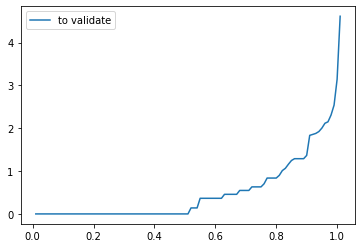

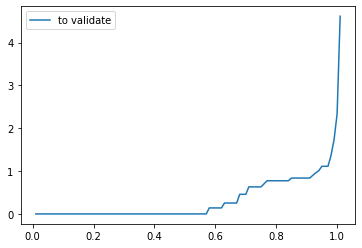

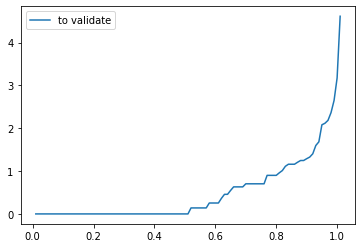

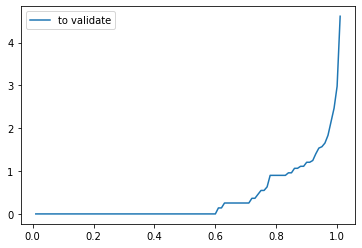

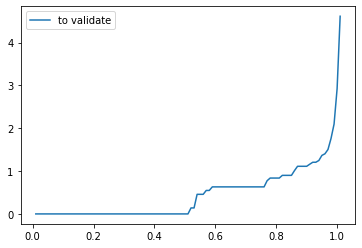

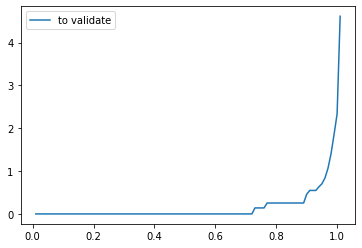

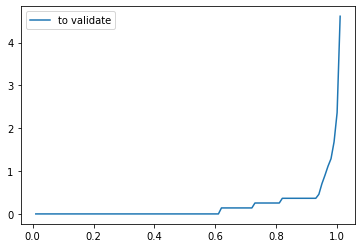

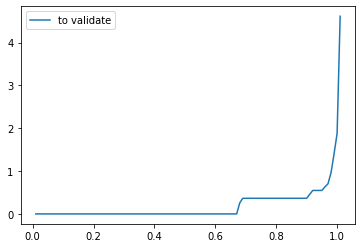

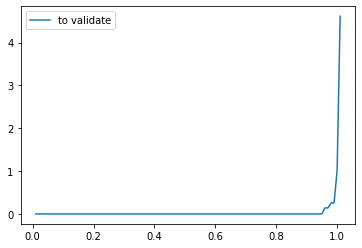

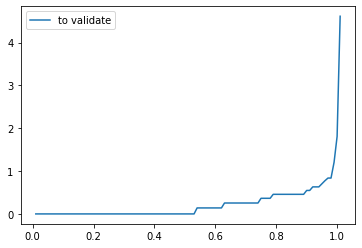

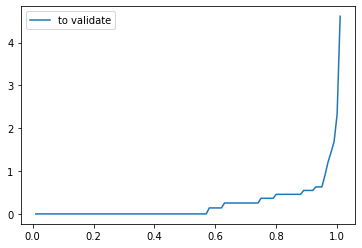

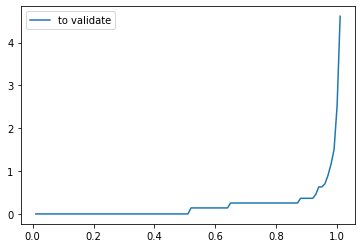

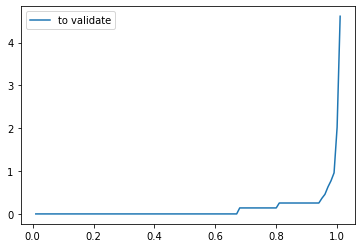

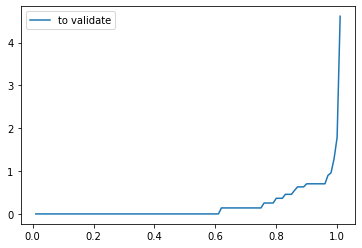

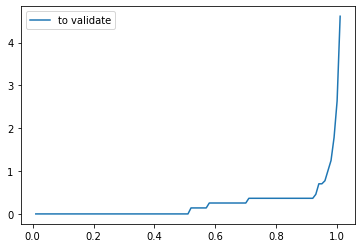

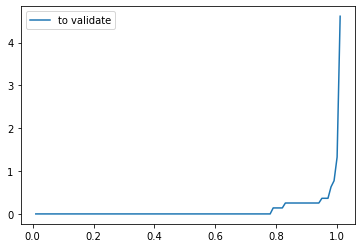

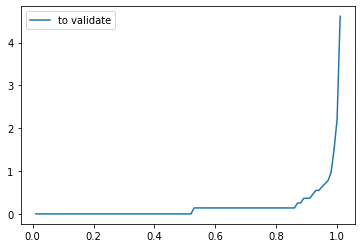

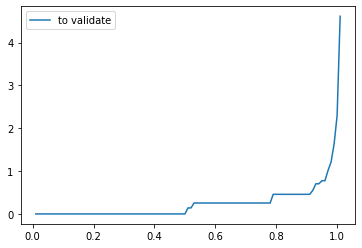

In [84]:

for index, model_name in enumerate(models):
    ds = datasets[model_name]['df_validation']
    
    to_validate, confidences = get_plot_confidence_and_validate_points(ds)
    
    plt.plot(confidences, np.log(to_validate + 1), label = "to validate")
    plt.legend()
    plt.show()

    

In [85]:
def get_plot_confidence_and_errors_points(ds):
    first_type_errors = []
    second_type_errors = []
    confidences = [i / 100 for i in range(1,102,1)]
    
    for confidence_level in range(1, 102, 1):
        
        confidence_level /= 100
        
        first_type_errors.append(first_type_errors_count(ds, confidence_level))
        
        second_type_errors.append(second_type_errors_count(ds, confidence_level))
        
    return np.array(first_type_errors), np.array(second_type_errors), np.array(confidences)

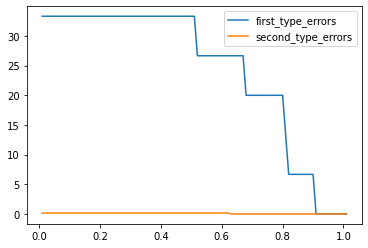

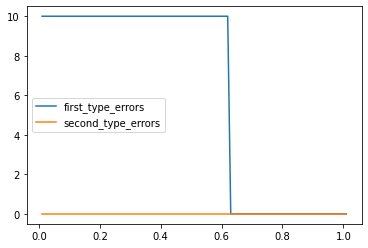

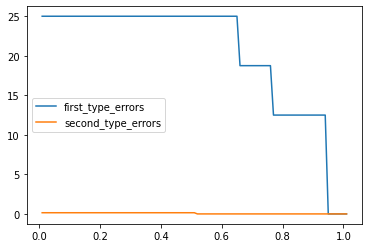

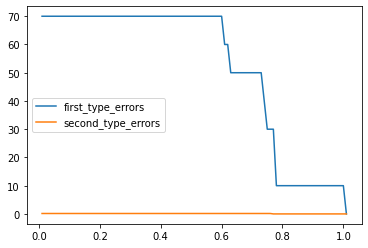

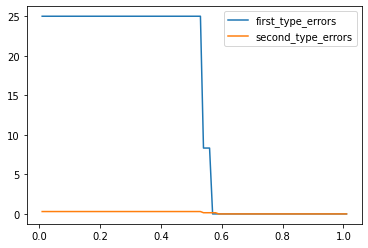

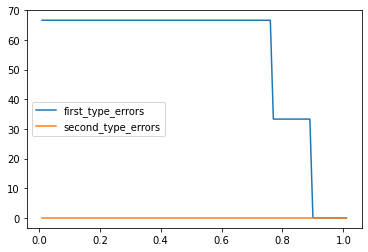

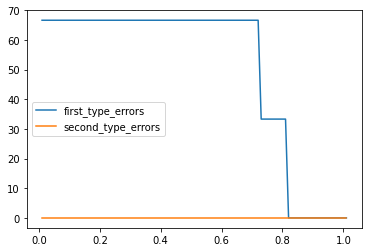

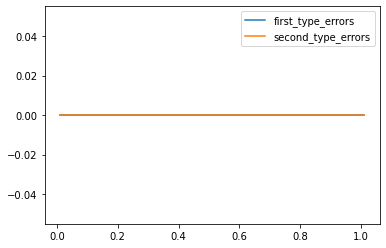

ZeroDivisionError: division by zero

In [86]:
for index, model_name in enumerate(models):
    ds = datasets[model_name]['df_validation']
    
    first_type_errors, second_type_errors, confidences = get_plot_confidence_and_errors_points(ds)
    
    plt.plot(confidences, first_type_errors, label = "first_type_errors")
    plt.plot(confidences, second_type_errors, label = "second_type_errors")
    plt.legend()
    plt.show()
